<a href="https://colab.research.google.com/github/mukvnd/custom_spam_ham_isaa_project/blob/main/isaa_spam_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score, log_loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
from nltk import word_tokenize
import string, re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Observe and cleanse the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection',  sep = '\t', header = None)

In [ ]:
df.columns

Int64Index([0, 1], dtype='int64')

In [ ]:
df['sms'] = df[1]
df['s_h'] = df[0]
df = df.drop(columns = [0,1], axis = 1)
df

,sms,s_h
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will ü b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [ ]:
df.isna().sum()

sms    0
s_h    0
dtype: int64

In [ ]:
df.duplicated().sum()

403

In [ ]:
df = df.drop_duplicates(keep = 'first')

## Exploratory data analysis

ham     4516
spam     653
Name: s_h, dtype: int64


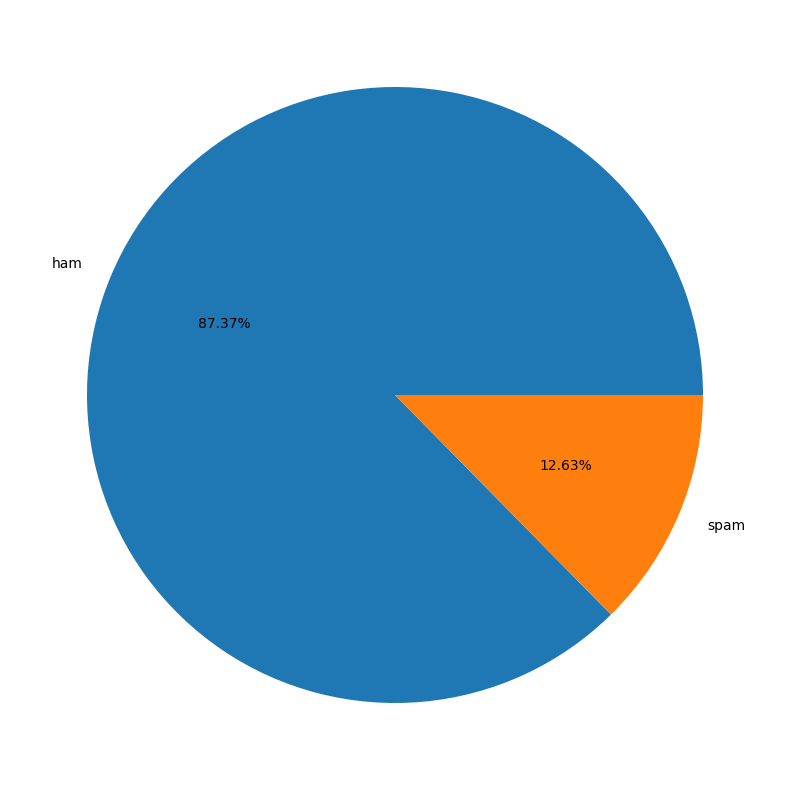

In [ ]:
print(df.s_h.value_counts()) #class imbalance seen
plt.figure(figsize=(10, 10))
plt.pie(df.s_h.value_counts(),labels = ['ham', 'spam'], autopct = "%.2f%%");

ham     714
spam    614
Name: s_h, dtype: int64


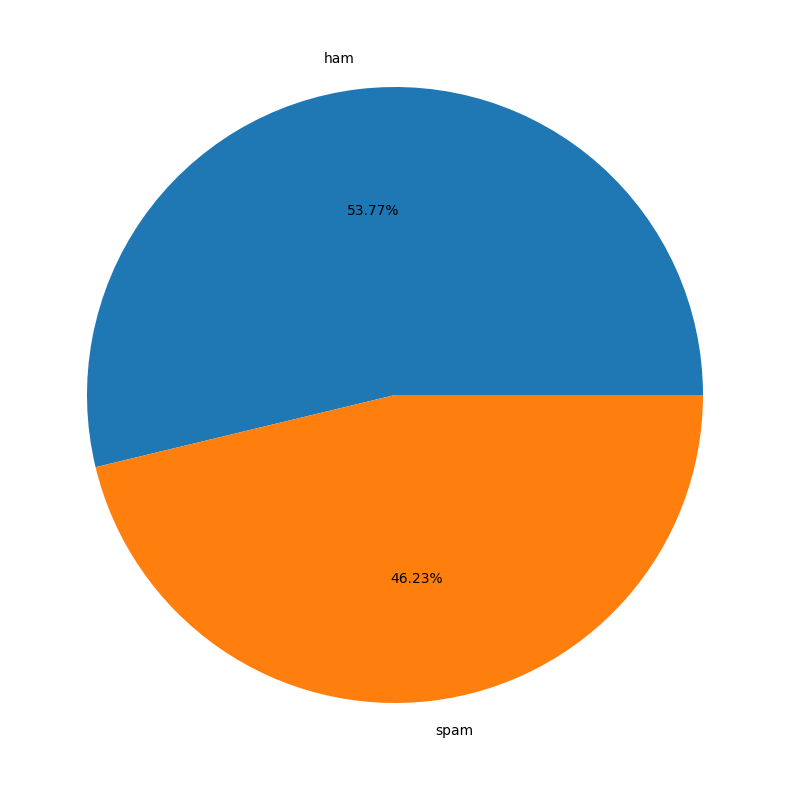

In [ ]:
#observe that the proportion between ham and spam drastically increases with inclusion of numbers in the text.
special_nums = set(string.digits)
nums_df = df[df['sms'].apply(lambda x: any(char in special_nums for char in x))]

print(nums_df.s_h.value_counts())
plt.figure(figsize=(10, 10))
plt.pie(nums_df.s_h.value_counts(),labels = ['ham', 'spam'], autopct = "%.2f%%");

#Steps to preprocess the given data

* convert it to lower case
* remove special characters, stop words and punctuations
* tokenize the sentence
* stemming and lemmitization of the text


In [ ]:
port_stemmer = PorterStemmer() #stemming with porter - trial 1
lan_stemmer = LancasterStemmer() #stemming with lancaster - trial 2
lemmatizer = WordNetLemmatizer() #lemmitization

In [ ]:
# Create a function to generate cleaned data from raw text
def clean_text(text):
    text = word_tokenize(text) # Create tokens
    text= " ".join(text) # Join tokens
    text = [char for char in text if char not in string.punctuation] # Remove punctuations
    text = ''.join(text) # Join the leters
    text = [char for char in text if char not in re.findall(r"[0-9]", text)] # Remove Numbers
    text = ''.join(text) # Join the leters
    text = [word.lower() for word in text.split() if word.lower() not in set(stopwords.words('english'))] # Remove common english words (I, you, we,...)
    text = ' '.join(text) # Join the leters
    # text = list(map(lambda x: lan_stemmer.stem(x), text.split()))
    text = list(map(lambda x: port_stemmer.stem(x), text.split()))
    # text = list(map(lambda x: lemmatizer.lemmatize(x), text.split()))
    return " ".join(text)   # error word

def clean_text_1(text):
  text = text.lower()
  text = word_tokenize(text)  # Create tokens

  text = [char for char in text if char not in string.punctuation]  # Remove punctuations

  text = ' '.join(text)  # Joining the letters
  text = [word.lower() for word in text.split() if word.lower() not in set(stopwords.words('english'))]  # Stopwords removed

  text = [lemmatizer.lemmatize(port_stemmer.stem(word)) for word in text] # Apply stemming and lemmatization to each word

  return " ".join(text)


In [ ]:
df['processed_sms'] = df['sms'].apply(clean_text_1)

<ipython-input-17-59736475a69f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_sms'] = df['sms'].apply(clean_text_1)


In [ ]:
df.head(30)

,sms,s_h,processed_sms
0,"Go until jurong point, crazy.. Available only ...",ham,go jurong point crazi .. avail bugi n great wo...
1,Ok lar... Joking wif u oni...,ham,ok lar ... joke wif u oni ...
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,U dun say so early hor... U c already then say...,ham,u dun say earli hor ... u c alreadi say ...
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah n't think goe usf live around though
5,FreeMsg Hey there darling it's been 3 week's n...,spam,freemsg hey darl 's 3 week 's word back 'd lik...
6,Even my brother is not like to speak with me. ...,ham,even brother like speak treat like aid patent
7,As per your request 'Melle Melle (Oru Minnamin...,ham,per request 'mell mell oru minnaminungint nuru...
8,WINNER!! As a valued network customer you have...,spam,winner valu network custom select receivea £90...
9,Had your mobile 11 months or more? U R entitle...,spam,mobil 11 month u r entitl updat latest colour ...


In [ ]:
df['characters'] = df['sms'].apply(len) #number of characters
df['words'] = df['sms'].apply(lambda x : len(nltk.word_tokenize(x))) #tokenize into words
df['sentences'] = df['sms'].apply(lambda x : len(nltk.sent_tokenize(x))) #tokenize into sentences

<ipython-input-19-19806c354038>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['characters'] = df['sms'].apply(len) #number of characters
<ipython-input-19-19806c354038>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words'] = df['sms'].apply(lambda x : len(nltk.word_tokenize(x))) #tokenize into words
<ipython-input-19-19806c354038>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [ ]:
df.head(10)

,sms,s_h,processed_sms,characters,words,sentences
0,"Go until jurong point, crazy.. Available only ...",ham,go jurong point crazi .. avail bugi n great wo...,111,24,2
1,Ok lar... Joking wif u oni...,ham,ok lar ... joke wif u oni ...,29,8,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entri 2 wkli comp win fa cup final tkt 21...,155,37,2
3,U dun say so early hor... U c already then say...,ham,u dun say earli hor ... u c alreadi say ...,49,13,1
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah n't think goe usf live around though,61,15,1
5,FreeMsg Hey there darling it's been 3 week's n...,spam,freemsg hey darl 's 3 week 's word back 'd lik...,147,39,4
6,Even my brother is not like to speak with me. ...,ham,even brother like speak treat like aid patent,77,18,2
7,As per your request 'Melle Melle (Oru Minnamin...,ham,per request 'mell mell oru minnaminungint nuru...,160,31,2
8,WINNER!! As a valued network customer you have...,spam,winner valu network custom select receivea £90...,157,32,5
9,Had your mobile 11 months or more? U R entitle...,spam,mobil 11 month u r entitl updat latest colour ...,154,31,3


In [ ]:
from wordcloud import WordCloud #better visualiazation of frequent and favorite words
wc = WordCloud(width = 1000, height = 1000, min_font_size = 5, background_color = 'Black')

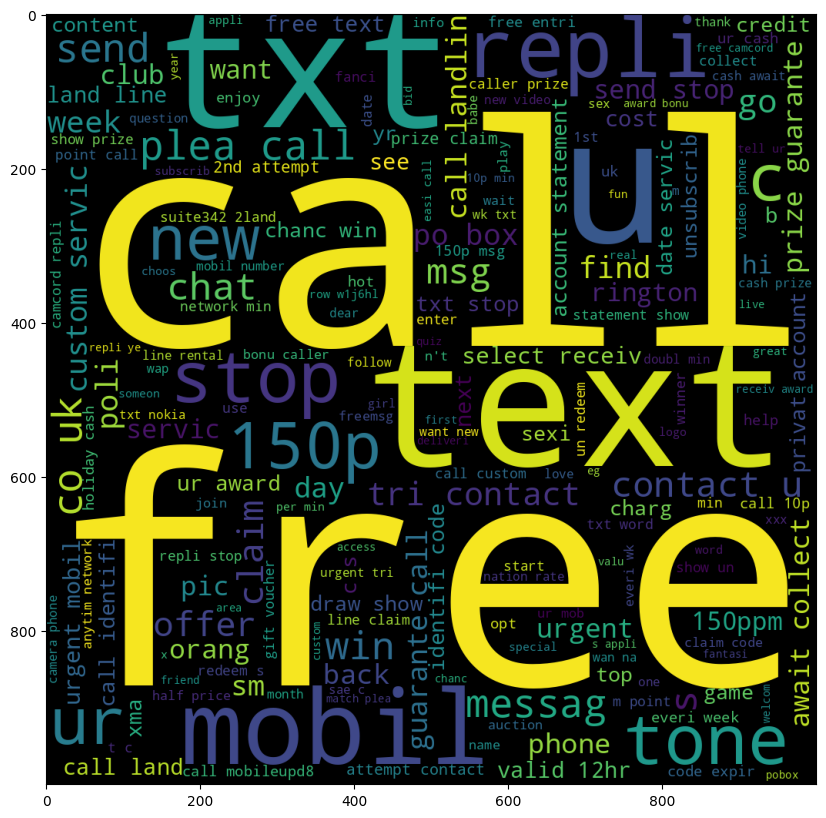

In [ ]:
spam_plot = wc.generate(df[df['s_h']=='spam']['processed_sms'].str.cat(sep =' '));
plt.figure(figsize = (30,10))
plt.imshow(spam_plot)

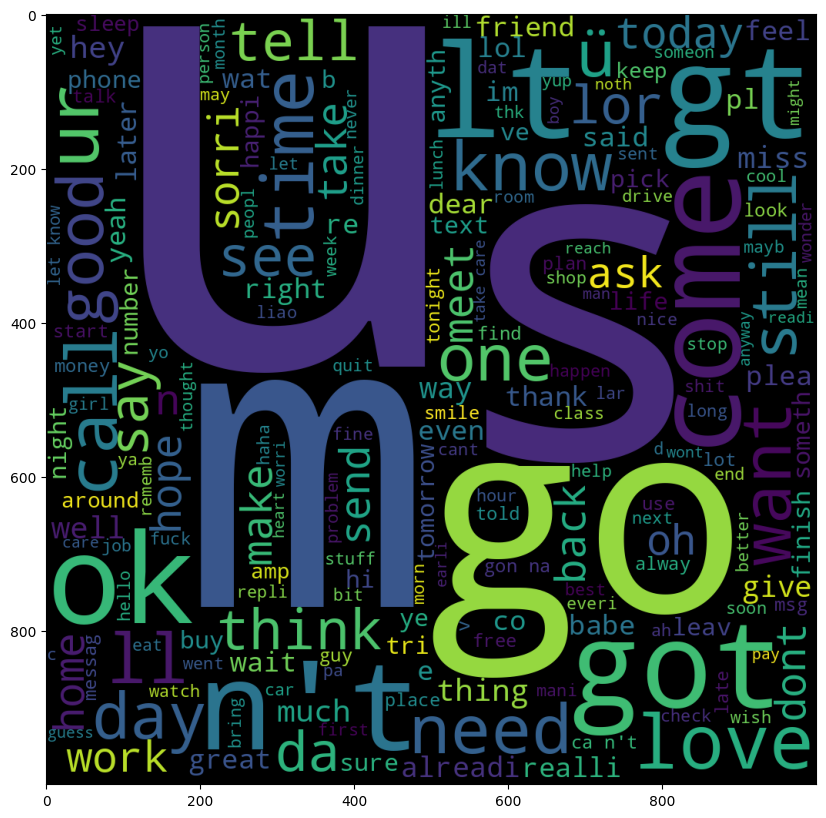

In [ ]:
ham_plot = wc.generate(df[df['s_h']=='ham']['processed_sms'].str.cat(sep = ' '));
plt.figure(figsize = (30,10))
plt.imshow(ham_plot);

In [ ]:
spam_word_list = []

for msg in df[df['s_h'] == 'spam']['processed_sms'].tolist():
  for word in msg.split():
    spam_word_list.append(word)


ham_word_list = []
for msg in df[df['s_h'] == 'ham']['processed_sms'].tolist():
  for word in msg.split():
    ham_word_list.append(word)

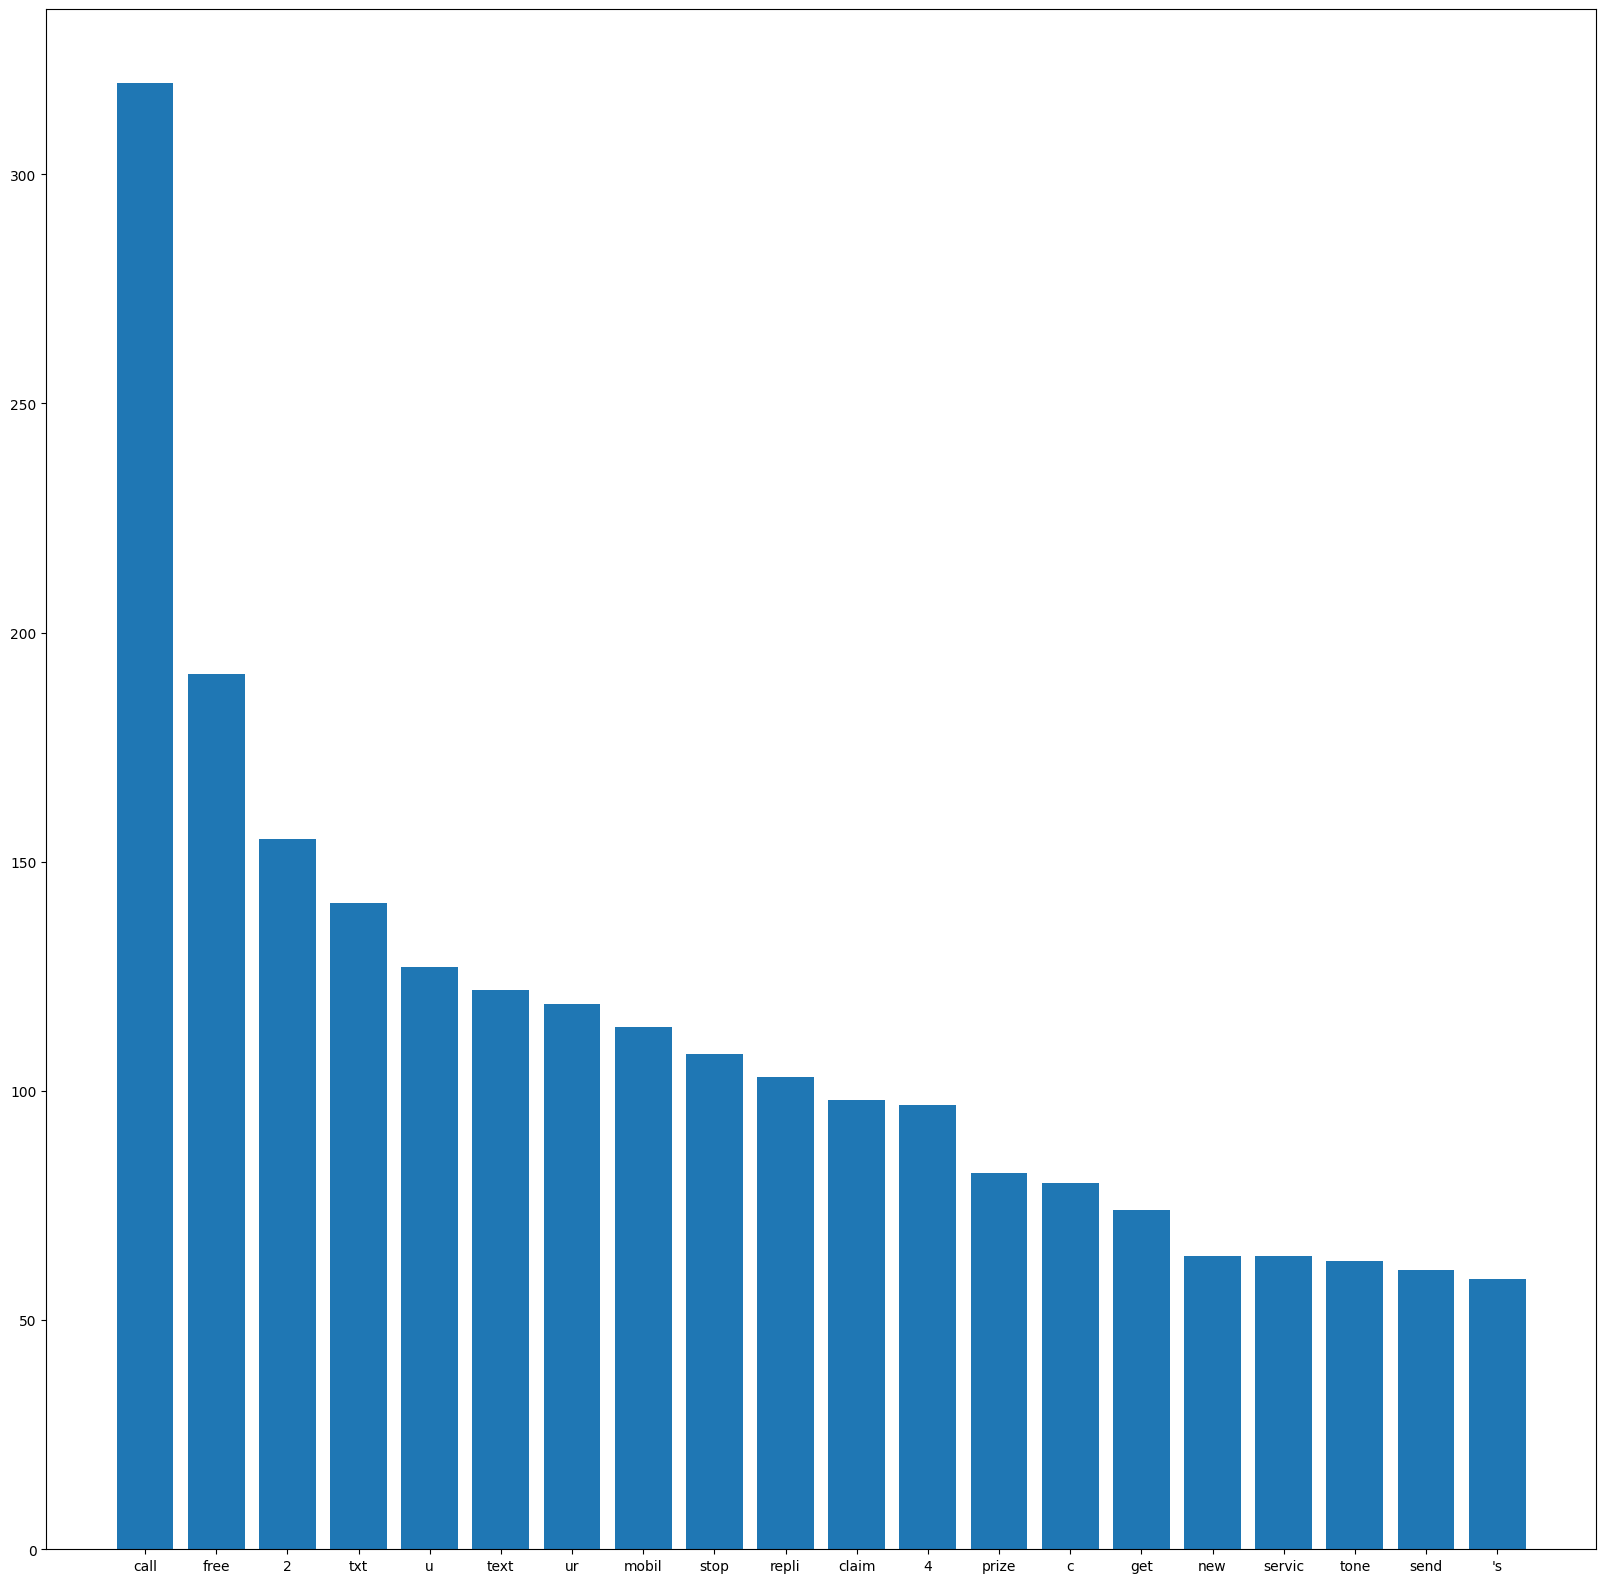

In [ ]:
# counting the 20 most common words in a spam text
plt.figure(figsize = (20, 20))
plt.bar(pd.DataFrame(Counter(spam_word_list).most_common(20))[0], pd.DataFrame(Counter(spam_word_list).most_common(20))[1])
plt.show()

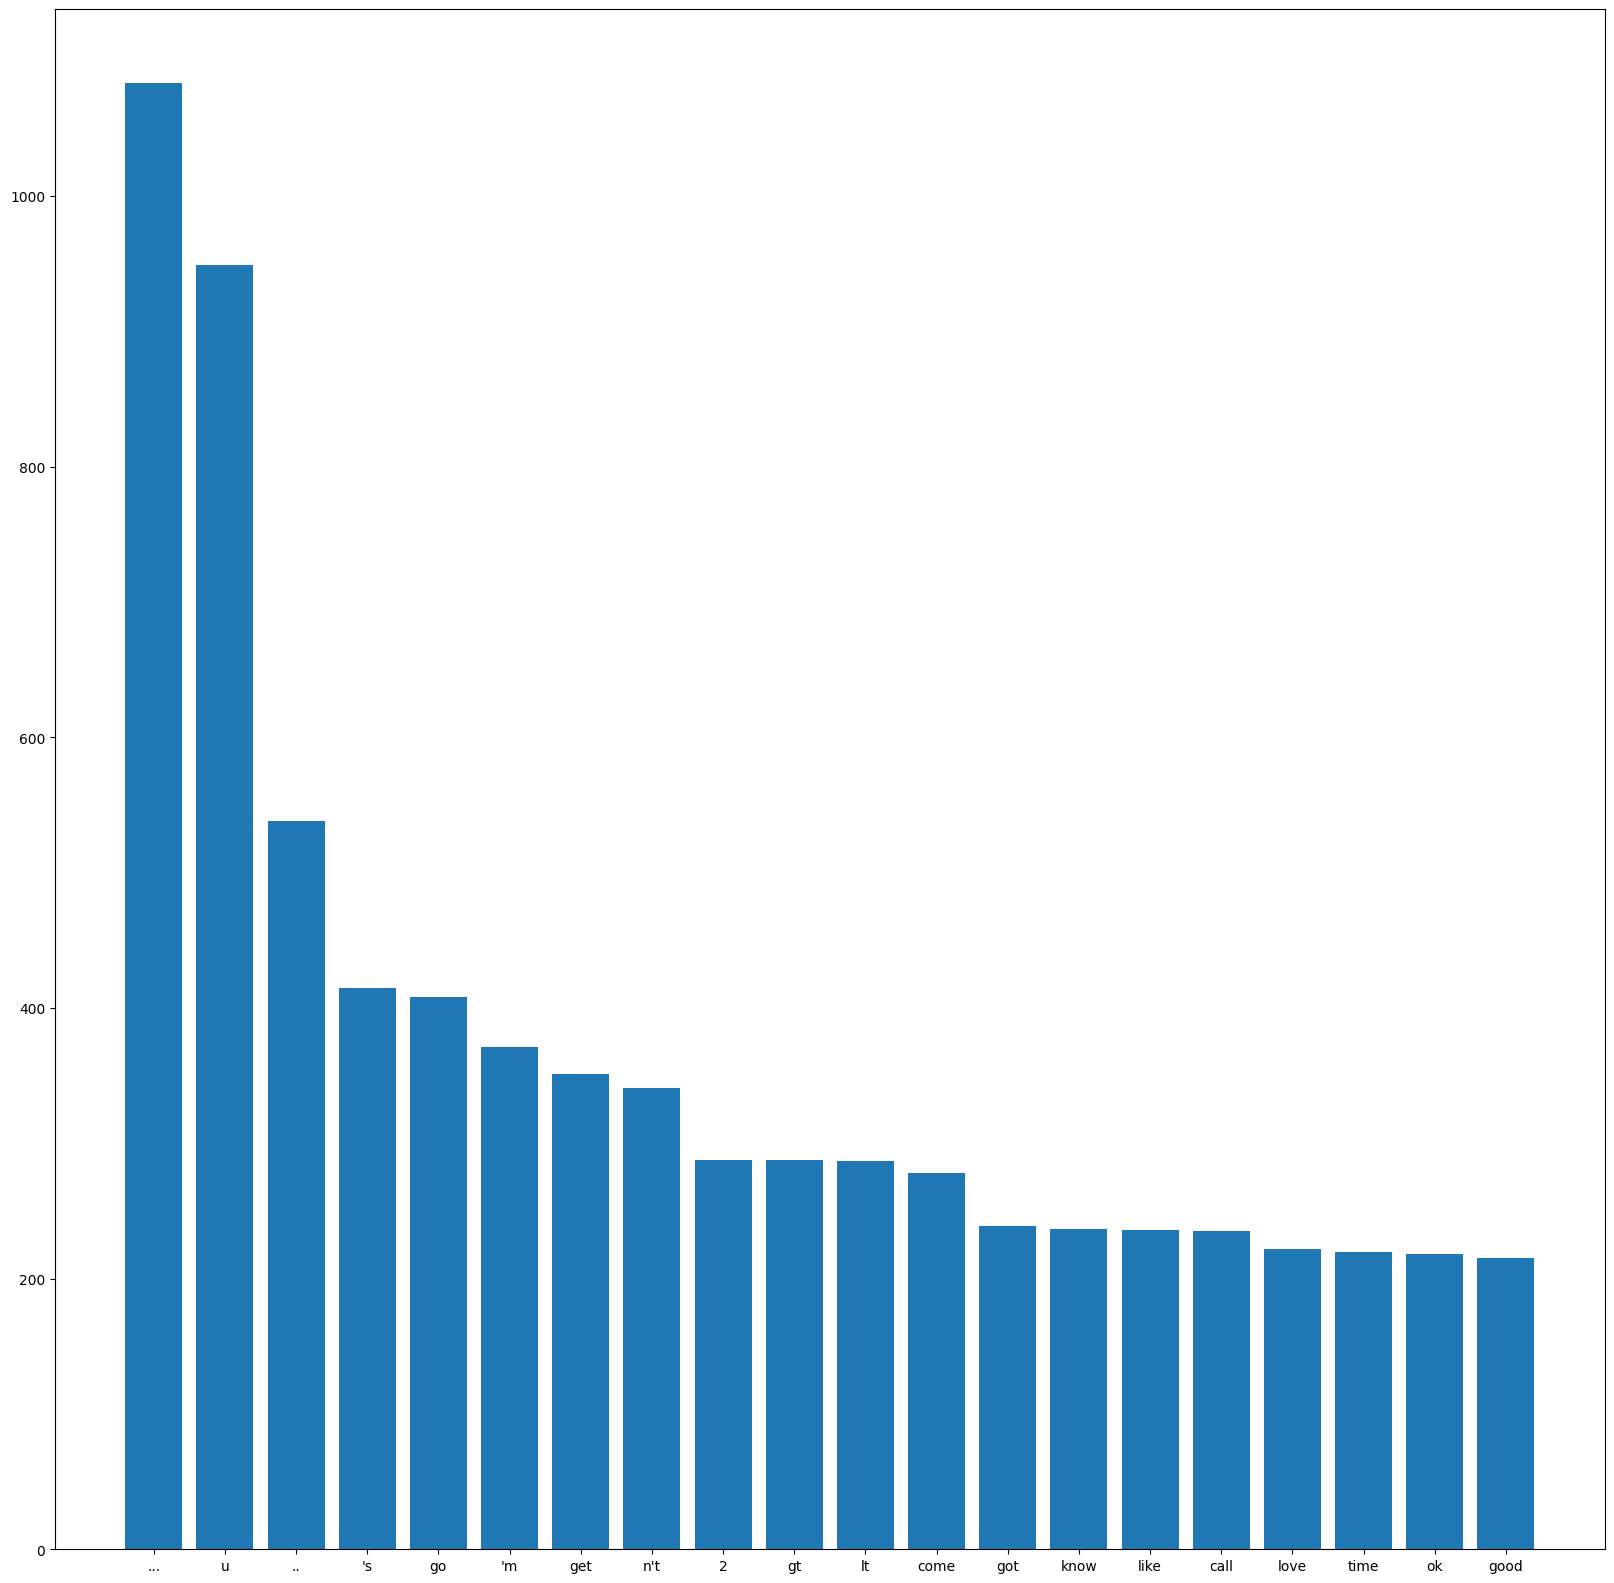

In [ ]:
plt.figure(figsize = (20, 20))
plt.bar(pd.DataFrame(Counter(ham_word_list).most_common(20))[0], pd.DataFrame(Counter(ham_word_list).most_common(20))[1])
plt.show()

In [ ]:
#encode the target values for model training
encoder = LabelEncoder()

# Fit and transform the labels
df['s_h_enc'] = encoder.fit_transform(df['s_h'])

<ipython-input-27-a89f78d20367>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['s_h_enc'] = encoder.fit_transform(df['s_h'])


In [ ]:
df = df.drop(columns = 's_h')

In [ ]:
df.s_h_enc.value_counts()

0    4516
1     653
Name: s_h_enc, dtype: int64

#Trial and testing of various models

In [ ]:
# using TFIDF to vectorize the textual data
tf = TfidfVectorizer(max_features = 3000)
X = tf.fit_transform(df['processed_sms']).toarray()
X.shape

(5169, 3000)

In [ ]:
y = df['s_h_enc'].values

In [ ]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##Using a variety of algorithms with default parameters and checking which one is the best out of them.

In [ ]:
models = []
models.append(('Logistic Regression', LogisticRegression()) )
models.append((('Decision Tree Classifier', DecisionTreeClassifier())))
models.append(('Random Forest Classifier', RandomForestClassifier()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('Support Vector Machine', SVC()))
models.append(('Naive Bayes: Multinomial', MultinomialNB()))
models.append(('Naive Bayes: Bernoulli', BernoulliNB()))
models.append(('Naive Bayes: Gaussian', GaussianNB()))

##Due to class imbalance, we will be using the F1 score as the main metric. Our aim is to figure out more spam, so will be using the F1 score and the recall.

In [ ]:
mod = []
f1 = []
recall = []
accuracy = []
precision = []

for name, model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mod.append(name)

  # metrics - f1, recall, precision and accuracy score
  f1.append(f1_score(y_test, y_pred))
  recall.append(recall_score(y_test, y_pred))
  accuracy.append(accuracy_score(y_test, y_pred))
  precision.append(precision_score(y_test, y_pred))

model_details = pd.DataFrame({'model used': mod,
                              'accuracy':accuracy,
                              'precision':precision,
                              'recall':recall,
                              'f1 Score':f1})

In [ ]:
model_details = model_details.sort_values(by = 'f1 Score', ascending = False)

In [ ]:
model_details

,model used,accuracy,precision,recall,f1 Score
6,Naive Bayes: Bernoulli,0.982592,1.000000,0.870504,0.930769
4,Support Vector Machine,0.979691,1.000000,0.848921,0.918288
5,Naive Bayes: Multinomial,0.976789,1.000000,0.827338,0.905512
2,Random Forest Classifier,0.975822,0.983051,0.834532,0.902724
1,Decision Tree Classifier,0.957447,0.846715,0.834532,0.840580
0,Logistic Regression,0.958414,0.970588,0.712230,0.821577
7,Naive Bayes: Gaussian,0.882012,0.537778,0.870504,0.664835
3,KNeighborsClassifier,0.902321,1.000000,0.273381,0.429379


In [ ]:
model_random = RandomForestClassifier()
model_random.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
model_bnb = BernoulliNB()
model_bnb.fit(X_train, y_train)

BernoulliNB()

In [ ]:
sms = "Congrats! You've won $18736 to be deposited in your bank account! Click on this link below to claim your winnings."
sms_2 = "Hi! How is everything?"
transformed_sms = clean_text_1(sms)
transformed_sms_2 = clean_text_1(sms_2)

vect_input = tf.transform([transformed_sms])
vect_input_2 = tf.transform([transformed_sms_2])

result = model_bnb.predict(vect_input)[0]
result_2 = model_bnb.predict(vect_input_2)[0]

if result == 1:
  print("Spam")
else:
  print("Not Spam")

if result_2 == 1:
  print("Spam")
else:
  print("Not Spam")

Spam
Not Spam


##Now that we have a good model (random forest regressor), we will change the way we transform the text using deep learning, mainly LSTMs


In [ ]:
import tensorflow as tf

In [ ]:
import seaborn as sns
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, Bidirectional

In [ ]:
data_dl = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection', sep ='\t',names=["label", "message"])
data_dl.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


Below, we further explore about the data by label groups. Let's create a WordCloud and distribution bar chart to visualize the data.

In [ ]:
# get all the ham and spam emails
ham_msg = data_dl[data_dl.label =='ham']
spam_msg = data_dl[data_dl.label=='spam']

ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In [ ]:
# downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [ ]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [ ]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

<ipython-input-51-742b017fc9d7>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


In [ ]:
msg_df.label.value_counts()

ham     747
spam    747
Name: label, dtype: int64

Next, a final dataframe is created and calculated the text length column. We further explored length of each of the text by lable types. On average, the ham message has length of 73 words whereas spam message has 138.

In [ ]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

<ipython-input-55-88d1e5e59715>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = msg_df.groupby('label').mean()


,text_length
label,
ham,73.238286
spam,138.670683


## Prepare train test data and pre-processing text
First, we need to convert the text label to numeric and split the data into training set and testing set. Also, convert label to numpy arrays to fit deep learning models. 80% of data were used for training and 20% for testing purposes.

In [ ]:
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [ ]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

#### Tokenization
As deep learning models do not understand text, we need to convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer will do all required pre-processing such as
- tokenize into word or charachter - here its at word level
- num_words for maximum number of unique tokens hence we can filter out rare words
- filter out punctuation terms
- convert all words to lower case
- convert all words to integer index

Below, let's define hyper-parameters used for Tokenization. These hyper-parmaters are briefly discussed as we use these in the code.

In [ ]:
# hyperparamaters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
# check how many unique tokens have been created
tot_words = len(word_index)
print('unique tokens -> ', tot_words)

unique tokens ->  4169


#### Sequencing and Padding

Once tokenization is done, let's represent each sentence by sequences of numbers using texts_to_sequences from tokenizer object. Subsequently, we padded the sequence so that we can have same length of each sequence.  Sequencing and padding are done for both training and testing data.

In [ ]:
# sequencing + padding
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

- padding = 'pre' or 'post (default pre). By using pre, we'll pad before each sequence and post will pad after each sequence.
- maxlen = maximum length of all sequences. If not provided, by default it will use the maximum length of the longest sentence.
- truncating = 'pre' or 'post' (default 'pre'). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. 'pre' option will truncate at the beginning where as 'post' will truncate at the end of the sequences.

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [ ]:
# padding to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [ ]:
# testing
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Train the custom model

In [ ]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16

In [ ]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 12)                300       
                                                                 
 dropout_2 (Dropout)         (None, 12)                0         
                                                      

Using 'binary_crossentropy' as a loss function because of binary output. We used 'adam' as an optimiser which makes use of  momentum to avoid local minima and 'accuracy' as a measure of model performance. We can now use accuracy as the dataset is not imbalanced

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

Next let's fit our dense classifier using model.fit argument. It uses padded training data and training labels for training the model and validation data for validating.

* Epoch: Number of times the learning algorithm will work through the entire training data set. We set it to be 20.
* callbacks: callbacks is used to pass the early stopping parameter. EarlyStopping(monitor='val_loss', patience=2) was used to define that we want to monitor the validation loss and if the validation loss is not improved after two epochs, then the model training is stopped. It helps to avoid overfitting problem and indicates when to stop training before the learner begins over-fit.
* verbose =2: lets to print loss and accuracy on each epoch

In [ ]:
# fitting a dense nerual network model
run = model.fit(training_padded, train_labels,
                    epochs=30,
                    validation_data=(testing_padded, test_labels), verbose=2)

Epoch 1/30
38/38 - 5s - loss: 0.6920 - accuracy: 0.6259 - val_loss: 0.6889 - val_accuracy: 0.7425 - 5s/epoch - 131ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6816 - accuracy: 0.7833 - val_loss: 0.6686 - val_accuracy: 0.8261 - 224ms/epoch - 6ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6405 - accuracy: 0.8134 - val_loss: 0.5955 - val_accuracy: 0.7893 - 179ms/epoch - 5ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5333 - accuracy: 0.8310 - val_loss: 0.4689 - val_accuracy: 0.8662 - 195ms/epoch - 5ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4320 - accuracy: 0.8879 - val_loss: 0.3890 - val_accuracy: 0.8829 - 195ms/epoch - 5ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3549 - accuracy: 0.9079 - val_loss: 0.3146 - val_accuracy: 0.8997 - 174ms/epoch - 5ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2748 - accuracy: 0.9347 - val_loss: 0.2387 - val_accuracy: 0.9231 - 199ms/epoch - 5ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2259 - accuracy: 0.9381 - val_loss: 0.1918 - val_accuracy: 0.9365 - 184ms/epoch - 5ms/step
Epoch 9/30
38/38 

In [ ]:
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.9532


[0.12142518162727356, 0.953177273273468]

In [ ]:
metrics = pd.DataFrame(run.history)
metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.691975,0.625941,0.688894,0.742475
1,0.681620,0.783264,0.668650,0.826087


In [ ]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss',
                          'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss',
                          'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.691975,0.625941,0.688894,0.742475
1,0.681620,0.783264,0.668650,0.826087


In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

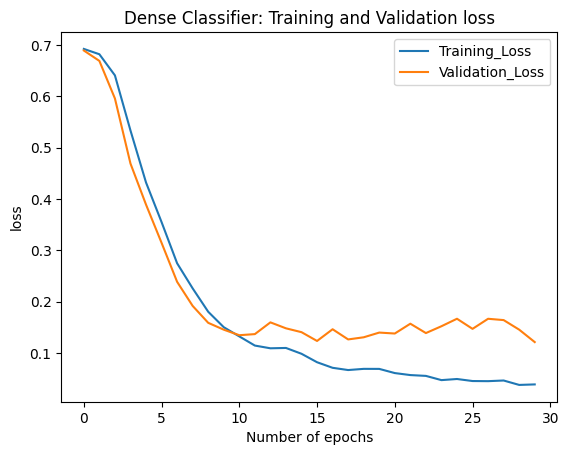

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

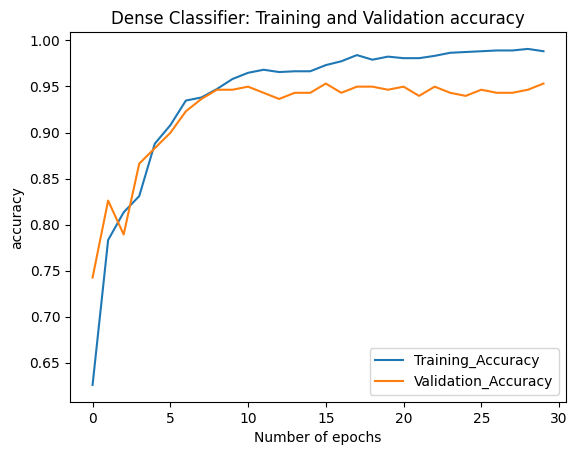

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
#hyperparameters
n_lstm = 20
drop_lstm =0.2

In [ ]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(4, activation='relu'))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm_12 (LSTM)              (None, 50, 20)            2960      
                                                                 
 lstm_13 (LSTM)              (None, 50, 20)            3280      
                                                                 
 dense_20 (Dense)            (None, 50, 64)            1344      
                                                                 
 dropout_7 (Dropout)         (None, 50, 64)            0         
                                                                 
 dense_21 (Dense)            (None, 50, 32)            2080      
                                                                 
 dense_22 (Dense)            (None, 50, 16)           

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Training
num_epochs = 30
history = model1.fit(training_padded, train_labels, epochs=num_epochs,
                    validation_data=(testing_padded, test_labels), verbose=2)

Epoch 1/30
38/38 - 12s - loss: 0.6801 - accuracy: 0.5054 - val_loss: 0.6345 - val_accuracy: 0.4716 - 12s/epoch - 308ms/step
Epoch 2/30
38/38 - 2s - loss: 0.4606 - accuracy: 0.8502 - val_loss: 0.4106 - val_accuracy: 0.9532 - 2s/epoch - 57ms/step
Epoch 3/30
38/38 - 2s - loss: 0.2663 - accuracy: 0.9464 - val_loss: 0.1841 - val_accuracy: 0.9465 - 2s/epoch - 55ms/step
Epoch 4/30
38/38 - 3s - loss: 0.1138 - accuracy: 0.9657 - val_loss: 0.1166 - val_accuracy: 0.9565 - 3s/epoch - 83ms/step
Epoch 5/30
38/38 - 3s - loss: 0.1204 - accuracy: 0.9640 - val_loss: 0.1341 - val_accuracy: 0.9565 - 3s/epoch - 85ms/step
Epoch 6/30
38/38 - 2s - loss: 0.0891 - accuracy: 0.9732 - val_loss: 0.1957 - val_accuracy: 0.9498 - 2s/epoch - 66ms/step
Epoch 7/30
38/38 - 2s - loss: 0.0669 - accuracy: 0.9808 - val_loss: 0.1686 - val_accuracy: 0.9565 - 2s/epoch - 56ms/step
Epoch 8/30
38/38 - 2s - loss: 0.0577 - accuracy: 0.9833 - val_loss: 0.2180 - val_accuracy: 0.9599 - 2s/epoch - 56ms/step
Epoch 9/30
38/38 - 2s - loss:

In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

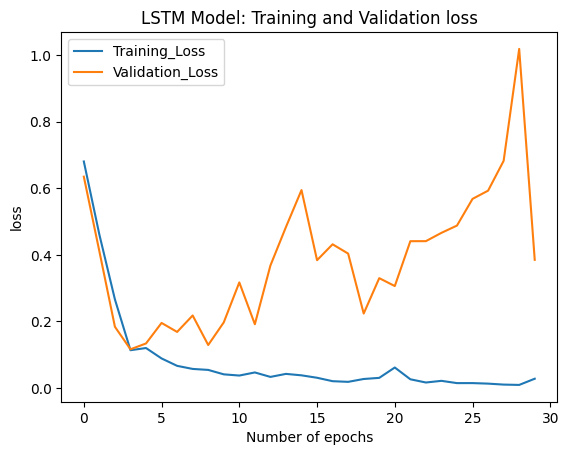

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

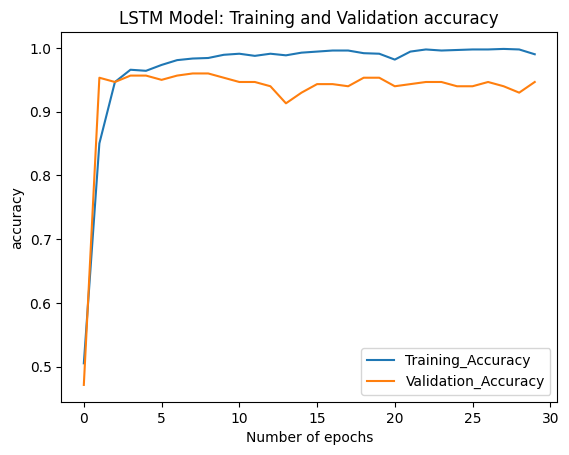

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

#### Biderectional LSTM (Bi-LSTM) Spam detection architecture
Unlike in LSTM, the Bi-LSTM learns patterns from both before and after a given token within a document. The Bi-LSTM backpropagates in both backward and forward directions in time.  Due to this, the computational time is increased compared to LSTM. However, in most of the cases Bi-LSTM results in better accuracy.

Below, we can see the Bi-derectional LSTM architechure where only difference than LSTM is that we use Bidirectional wrapper to LSTM.

In [ ]:
# Biderectional LSTM
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 dense_25 (Dense)            (None, 50, 16)            656       
                                                                 
 dropout_9 (Dropout)         (None, 50, 16)            0         
                                                                 
 dense_26 (Dense)            (None, 50, 4)             68        
                                                                 
 flatten_2 (Flatten)         (None, 200)               0         
                                                      

In [ ]:
# Training
num_epochs = 30
history = model2.fit(training_padded, train_labels, epochs=num_epochs,
                    validation_data=(testing_padded, test_labels), verbose=2)

Epoch 1/30
38/38 - 6s - loss: 0.0507 - accuracy: 0.9841 - val_loss: 0.1492 - val_accuracy: 0.9465 - 6s/epoch - 155ms/step
Epoch 2/30
38/38 - 3s - loss: 0.0450 - accuracy: 0.9833 - val_loss: 0.2039 - val_accuracy: 0.9298 - 3s/epoch - 81ms/step
Epoch 3/30
38/38 - 2s - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.2014 - val_accuracy: 0.9398 - 2s/epoch - 63ms/step
Epoch 4/30
38/38 - 2s - loss: 0.0276 - accuracy: 0.9925 - val_loss: 0.1904 - val_accuracy: 0.9465 - 2s/epoch - 44ms/step
Epoch 5/30
38/38 - 2s - loss: 0.0221 - accuracy: 0.9950 - val_loss: 0.1720 - val_accuracy: 0.9532 - 2s/epoch - 45ms/step
Epoch 6/30
38/38 - 2s - loss: 0.0268 - accuracy: 0.9925 - val_loss: 0.2274 - val_accuracy: 0.9398 - 2s/epoch - 57ms/step
Epoch 7/30
38/38 - 3s - loss: 0.0259 - accuracy: 0.9925 - val_loss: 0.3264 - val_accuracy: 0.9365 - 3s/epoch - 77ms/step
Epoch 8/30
38/38 - 4s - loss: 0.0243 - accuracy: 0.9950 - val_loss: 0.2539 - val_accuracy: 0.9365 - 4s/epoch - 105ms/step
Epoch 9/30
38/38 - 4s - loss: 

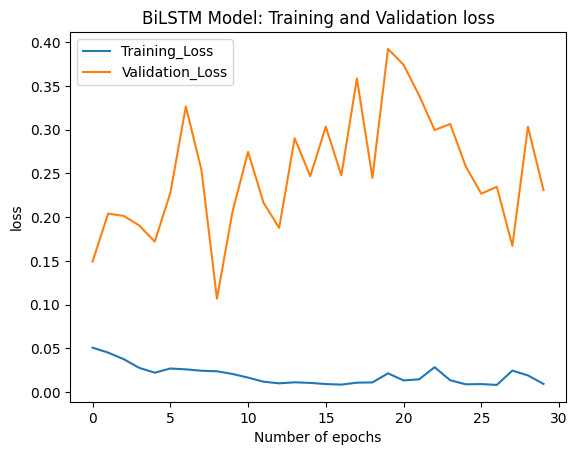

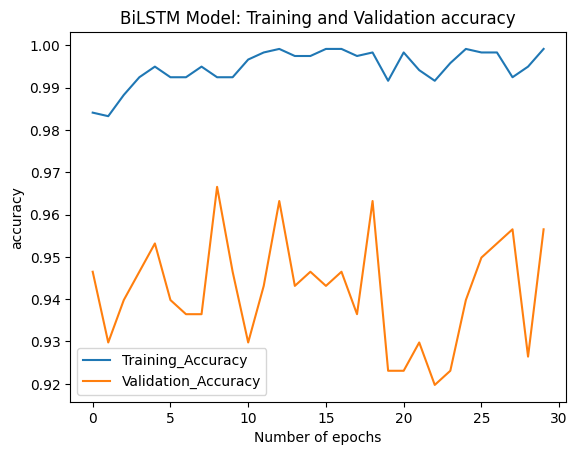

In [ ]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss',
                          'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss',
                          'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
# Comparing the three models used
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.9532
Dense architecture loss and accuracy: [0.12142518162727356, 0.953177273273468] 
10/10 [==============================] - 0s 17ms/step - loss: 0.3849 - accuracy: 0.9465
LSTM architecture loss and accuracy: [0.38492003083229065, 0.9464883208274841] 
10/10 [==============================] - 0s 11ms/step - loss: 0.2308 - accuracy: 0.9565
Bi-LSTM architecture loss and accuracy: [0.23081643879413605, 0.95652174949646] 


In [ ]:
def predict_spam(predict_msg, model):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

predict_msg = ["You have won $100192",
               "where are you?",
               "You should click the link below to get flat 100% off on all our goods"]

In [ ]:
predict_spam(predict_msg, model) #custom model

1/1 [==============================] - 0s 97ms/step


array([[0.61115324],
       [0.00080968],
       [0.01979989]], dtype=float32)

In [ ]:
predict_spam(predict_msg, model1) #lstm

1/1 [==============================] - 0s 91ms/step


array([[0.06923402],
       [0.0017329 ],
       [0.00581925]], dtype=float32)

In [ ]:
predict_spam(predict_msg, model2) #bi-lstm

1/1 [==============================] - 0s 69ms/step


array([[9.7662520e-01],
       [6.2477123e-04],
       [3.6231158e-03]], dtype=float32)